## <font style="font-family:roboto;color:#455e6c"> Introduction to atomistic simulations with pyiron </font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> <b> Machine Learning Modalities for Materials Science Workshop, Jožef Stefan Institute, Ljubljana </b> </font> </br>
<font style="font-family:roboto;color:#455e6c"> 14 May 2024 </font>
</div>

### <font style="font-family:roboto;color:#455e6c"> Jupyter Crash Course </font>  

1. Select cells by clicking on them.
2. Navigate through with `up` and `down` keys (or `k` and `j` for you vimmers).
3. Press Enter to edit a cell.
4. Press Shift-Enter to execute it.
5. Create new cells above or below the current one with `a` or `b`.
6. Copy, cut and paste them with `c`, `x` and `v`.
7. Press `m` to turn a cell into a markdown cell.
8. See the `Help` in the toolbar for more.

Before the excercise, you should:

* Basic understanding of python especially with numerical libraries like numpy and plotting tools like matplotlib
* Understand how Jupyter Notebooks work (see above)

The aim of this exercise is to make you familiar with:

* A general overview of what pyiron can do
* How to set up atomic structures and run atomistic simulation codes through pyiron

### <font style="font-family:roboto;color:#455e6c"> Importing necessary libraries </font>  
As a first step we import the libraries [numpy](http://www.numpy.org/) for data analysis and [matplotlib](https://matplotlib.org/) for visualization.

In [1]:
import numpy as np
import matplotlib.pylab as plt

Fundamentally, we only need to import one module from `pyiron`: the `Project` class

In [2]:
from pyiron import Project

The Project object introduced below is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus, by code completion *Tab* the respective commands can be found easily.

We now create a pyiron Project named 'tutorial'.

### <font style="font-family:roboto;color:#455e6c"> Working with atomistic structures </font>  

#### <font style="font-family:roboto;color:#455e6c"> Creation of a project instance </font>  

In [3]:
pr = Project("tutorial")

The project name also applies for the directory that is created for the project. All data generated by this `Project` object resides in this directory.

In [4]:
pr.path

'/mnt/c/Users/menon/Documents/repos/projects-workshops/dpg_tutorial_2024/tutorial/tutorial/'

In [5]:
pr

{'groups': [], 'nodes': []}

The `groups` and `nodes` will be populated later, as we add jobs and sub project to it.

#### <font style="font-family:roboto;color:#455e6c"> Creating atomic structures </font>  

Every atomistic simulation needs an atomic structure. For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

Creating a bulk fcc cubic unitcell

In [6]:
Al_unitcell_cubic = pr.create.structure.bulk('Al', cubic=True, a=4.04)
Al_unitcell_cubic

Al: [0. 0. 0.]
Al: [0.   2.02 2.02]
Al: [2.02 0.   2.02]
Al: [2.02 2.02 0.  ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([4.04, 4.04, 4.04])

Creating a super cell.

In [7]:
Al_supercell_3_3_3 = Al_unitcell_cubic.repeat([3, 3, 3])
Al_supercell_3_3_3.plot3d(particle_size=2)

NGLWidget()

Creating a vacancy is easy, just delete an atom.

In [8]:
Al_vacancy = Al_supercell_3_3_3.copy()
del Al_vacancy[0] # Deleting the first atom
print(Al_supercell_3_3_3.get_chemical_formula(), Al_vacancy.get_chemical_formula())
Al_vacancy.plot3d(particle_size=2)

Al108 Al107


NGLWidget()

### <font style="font-family:roboto;color:#455e6c"> Running an atomistic calculation using interatomic potentials (with LAMMPS) </font>  


Once we have an atomic structure, we can set up a simulation "job" of any atomistic simulation that is intergrated within pyiron. In this section, we are going to use the popular [LAMMPS code](https://lammps.sandia.gov/).

In [9]:
# Create a job
job_lammps = pr.create.job.Lammps("lammps_job")

Every atomistic simulation code needs an input atomic structure. We use the Al supercell structure we created earlier

In [10]:
# Assign an atomic structure to the job
job_lammps.structure = pr.create.structure.bulk('Al', cubic=True).repeat(3)

Once the structure is assigned, an appropriate potential should also be chosen. This list of available for the structure containing Al can be found below.  This list originates from the NIST Interatomic Potential Database.

In [11]:
# See available potentials
job_lammps.list_potentials()[20:30]

['2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2',
 '2010--Lee-E--Fe-Al--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-1--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-2--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-3--LAMMPS--ipr1',
 '2010--Winey-J-M--Al--LAMMPS--ipr1',
 '2011--Apostol-F--Al-Cu--LAMMPS--ipr1',
 '2011--Ko-W-S--Al-H--LAMMPS--ipr1']

In [12]:
# Choose one of these potentials
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"

At this stage, the computational parameters for the simulation needs to be specified. pyiron parses generic computational parameters into code specific parameters allowing for an easy transition between simulation codes

In [13]:
# specify calculation details: in this case: MD at 800 K in the NPT ensemble (pressure=0) for 10000 steps
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)

We can now see how pyiron sets-up the corresponding LAMMPS input

In [14]:
job_lammps.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all npt temp 800.0 800.0 0.1 iso 0.0 0.0 1.0,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


Once the `run()` commmand is called, pyiron creates necessary input files, calls the simulation code, and finally parses and stores the output.

In [15]:
job_lammps.run()

The job lammps_job was saved and received the ID: 380


When printing the project, the saved job will also appear under `nodes` now.

In [16]:
pr

{'groups': [], 'nodes': ['lammps_job']}

You can get a quick overview with the `job_table` method.

In [17]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,380,finished,Al108,lammps_job,/lammps_job,None,/mnt/c/Users/menon/Documents/repos/projects-workshops/dpg_tutorial_2024/tutorial/tutorial/,2024-05-07 11:26:17.603998,2024-05-07 11:26:21.568068,3.0,pyiron@cmleo26#1,Lammps,0.1,None,None


Once it is finished we can access the parsed output.

In [18]:
job_lammps['output']

{'groups': ['generic'], 'nodes': []}

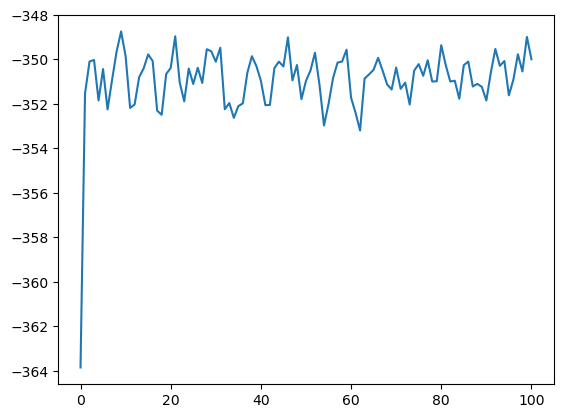

In [19]:
plt.plot(job_lammps['output/generic/energy_pot'])

### <font style="font-family:roboto;color:#455e6c"> Software used in this notebook </font>  

- [pyiron_atomistics](https://github.com/pyiron/pyiron_atomistics)
- [LAMMPS](https://www.lammps.org/)
- [pyXtal](https://pyxtal.readthedocs.io/en/latest/)